In [0]:
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose,LeakyReLU,Flatten,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from numpy.random import randn
import os
import numpy as np
from PIL import Image

Using TensorFlow backend.


In [0]:
!wget https://www.dropbox.com/s/2nvu2sv707l8jaf/ORLProcessed.zip
!unzip ORLProcessed.zip

--2020-05-30 15:14:03--  https://www.dropbox.com/s/2nvu2sv707l8jaf/ORLProcessed.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2nvu2sv707l8jaf/ORLProcessed.zip [following]
--2020-05-30 15:14:03--  https://www.dropbox.com/s/raw/2nvu2sv707l8jaf/ORLProcessed.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc193e5c5166f7b9a719a4c0f11c.dl.dropboxusercontent.com/cd/0/inline/A4uXG3AqSSmimLHuxSds4XqKyFby5-yTICtW5bgrIM3Kg88kIEzmfrMNTDR9kF7FRRYiGqmuNks9x3KZBN07g8racGX3B1F03QEo4kBCU-gB8SH0SGfbvj9a6UMgPNPrWQ0/file# [following]
--2020-05-30 15:14:04--  https://uc193e5c5166f7b9a719a4c0f11c.dl.dropboxusercontent.com/cd/0/inline/A4uXG3AqSSmimLHuxSds4XqKyFby5-yTICtW5bgrIM3Kg88kIEzmfrMNTDR9kF7FRRYiGqmuNks9x3KZBN07g8racGX3B1F03QEo4k

In [0]:
dir_path_train= "ORLProcessed/Train"


In [0]:
def read_pgm(name):
    with open(name) as f:
        lines = f.readlines()

    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    return (np.array(data[3:]),(data[1],data[0]),data[2])
def get_dataset_array(dirpath):
    images = []
    labels = []
    for usuario_sistema in os.listdir(dirpath):
        try:
            folderPath = os.path.join(dirpath,usuario_sistema)
            for file in os.listdir(folderPath):
                filePath = os.path.join(folderPath,file)
                data = read_pgm(filePath)
                images.append(data[0])
                tamañoImagen = data[1]
                labels.append(usuario_sistema)
        except:
            print("Error de lectura %s" % usuario_sistema)
    print("Imagenes procesadas %d total de individuos %d " %(len(images),len(set(labels))))
    return np.matrix(images),labels

In [0]:
imagesTrain,labelsTrain = get_dataset_array(dir_path_train)

Error de lectura .DS_Store
Imagenes procesadas 200 total de individuos 40 


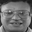

In [0]:
Image.fromarray(imagesTrain[100].reshape(112,92).astype(np.uint8)).resize((32,32))

In [0]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
	return model

In [0]:
model_generator = define_generator(100)

In [0]:
model_generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)      

In [0]:
def define_discriminator(in_shape=(32,32,1)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [0]:
model_discriminador  = define_discriminator()
model_discriminador.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)        

In [0]:
def genera_muestras_falsas(generador,dimension_vector,num_muestras):
  vector_puntos = randn(dimension_vector*num_muestras)
  vector_puntos = vector_puntos.reshape(num_muestras, dimension_vector)
  X = generador.predict(vector_puntos)
  Y = np.zeros((num_muestras,1))
  return X,Y

In [0]:
def genera_muestras_reales(datos):
  batch = np.zeros((200,32,32))
  #imagesTrain = imagesTrain[[np.random.permutation(200)]]
  for i in range(200):
    batch[i] = np.array(Image.fromarray(imagesTrain[i].reshape(112,92).astype(np.uint8)).resize((32,32))) /255.0
  y = np.ones((200,1))
  return batch.reshape(200,32,32,1),y

In [0]:
def crea_gan(generador,discriminador):
  discriminador.trainable = False
  model = Sequential([
                      generador,
                      discriminador
  ])
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [0]:
gan = crea_gan(model_generator,model_discriminador)

In [0]:
dimension = 100
muestras = 200
for i in range(5000):
  #Discriminador distingue reales
  x_real,y_real = genera_muestras_reales(imagesTrain)
  lossb,_ = model_discriminador.train_on_batch(x_real,y_real)

  #Discriminador distingue muestras faltas
  x_falso,y_falso = genera_muestras_falsas(model_generator,dimension,muestras)
  lossm,_ = model_discriminador.train_on_batch(x_falso,y_falso)
  vector_puntos = randn(dimension*muestras)
  x_gan = vector_puntos.reshape(muestras, dimension)
  y_gan = np.ones((muestras,1))
  loss_gan = gan.train_on_batch(x_gan,y_gan)
  print("epoch %d  loss discriminador buenas: %.3f loss discriminador malas %.3f loss gan %.3f" %(i,lossb,lossm,loss_gan))
  #print(i,loss_gan)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Se han truncado las últimas 5000 líneas del flujo de salida.
epoch 1  loss discriminador buenas: 0.628 loss discriminador malas 0.689 loss gan 0.743
epoch 2  loss discriminador buenas: 0.629 loss discriminador malas 0.701 loss gan 0.743
epoch 3  loss discriminador buenas: 0.631 loss discriminador malas 0.697 loss gan 0.756
epoch 4  loss discriminador buenas: 0.637 loss discriminador malas 0.692 loss gan 0.773
epoch 5  loss discriminador buenas: 0.647 loss discriminador malas 0.678 loss gan 0.772
epoch 6  loss discriminador buenas: 0.652 loss discriminador malas 0.681 loss gan 0.771
epoch 7  loss discriminador buenas: 0.652 loss discriminador malas 0.690 loss gan 0.751
epoch 8  loss discriminador buenas: 0.655 loss discriminador malas 0.694 loss gan 0.754
epoch 9  loss discriminador buenas: 0.661 loss discriminador malas 0.691 loss gan 0.754
epoch 10  loss discriminador buenas: 0.661 loss discriminador malas 0.679 loss gan 0.770
epoch 11  loss discriminador buenas: 0.665 loss discrimina

In [0]:
from matplotlib import pyplot as plt

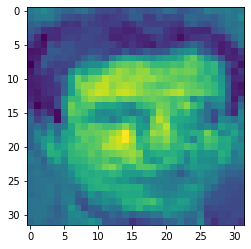

In [0]:
plt.imshow(model_generator.predict(randn(1,100))[0].reshape((32,32)))